In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
import ObsModels 

# $M = 2$, $A = 2$, $Y = 2$

In [117]:
NStepsObs = 50
NTraj = 100
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
observations.shape

(100, 50)

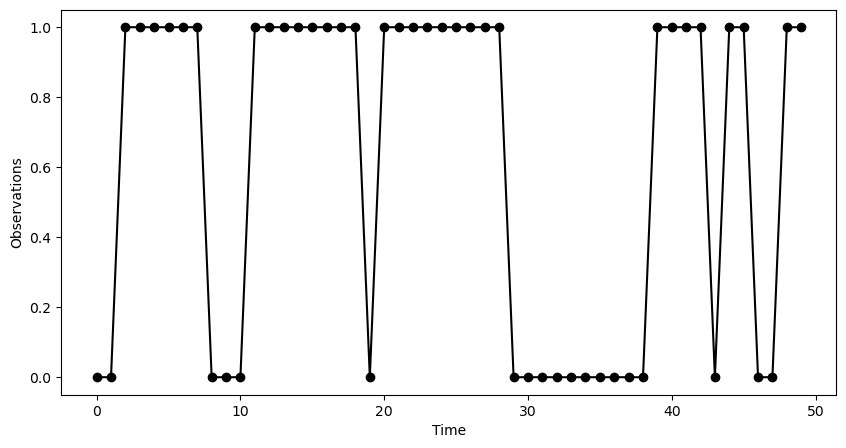

In [118]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [119]:
M = 2
A = 2
#Theta = np.random.randn(Y, M, M, A)

ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])

FSC = FSC_DiscreteObs(ThetaFollowSwitch, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [120]:
FSC.load_observations(observations)

In [124]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

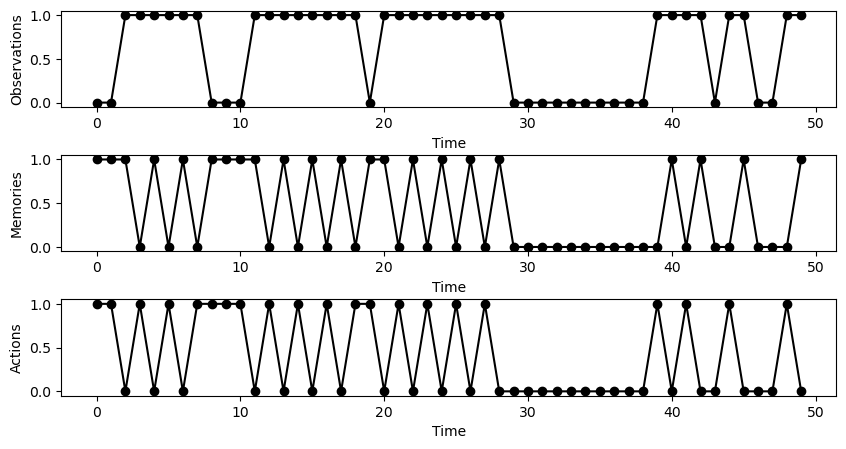

In [125]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = plt.subplots(3,1, figsize=(10,5))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(Time, trj["observations"], 'o', c= 'k')
ax[0].plot(Time, trj["observations"], c = 'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Observations')

ax[1].plot(Time, trj["memories"], 'o', c= 'k')
ax[1].plot(Time, trj["memories"], c = 'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Memories')

ax[2].plot(Time, trj["actions"], 'o', c= 'k')
ax[2].plot(Time, trj["actions"], c = 'k')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Actions')

plt.show()

In [126]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.3200768149434666

In [144]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(33.1832, device='mps:0', grad_fn=<SubBackward0>)

In [145]:
_, _ = FSC_tofit.optimize(NEpochs = 20, NBatch = 25, lr = 0.1)

Training with 80 trajectories and validating with 20 trajectories.
	 Epoch 1 - Batch 1 - Loss: 852.9227905273438
	 Epoch 1 - Batch 2 - Loss: 836.2973022460938
	 Epoch 1 - Batch 3 - Loss: 806.4592895507812
	 Epoch 1 - Batch 4 - Loss: 152.46556091308594
Epoch 1 - Training loss: 105.92579772949219, Validation loss: 588.144287109375
	 Epoch 2 - Batch 1 - Loss: 731.6981811523438
	 Epoch 2 - Batch 2 - Loss: 737.5053100585938
	 Epoch 2 - Batch 3 - Loss: 709.2255249023438
	 Epoch 2 - Batch 4 - Loss: 141.85037231445312
Epoch 2 - Training loss: 92.81117553710938, Validation loss: 516.2677001953125
	 Epoch 3 - Batch 1 - Loss: 682.2603759765625
	 Epoch 3 - Batch 2 - Loss: 654.7953491210938
	 Epoch 3 - Batch 3 - Loss: 599.25
	 Epoch 3 - Batch 4 - Loss: 106.9609603881836
Epoch 3 - Training loss: 81.73066741943359, Validation loss: 443.8944091796875
	 Epoch 4 - Batch 1 - Loss: 575.0331420898438
	 Epoch 4 - Batch 2 - Loss: 532.2835693359375
	 Epoch 4 - Batch 3 - Loss: 506.00030517578125
	 Epoch 4 - Ba

In [146]:
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.8019, device='mps:0', grad_fn=<SubBackward0>)

In [147]:
FSC_tofit.TMat.detach().cpu().numpy(), FSC.TMat

(array([[[[9.9724352e-01, 5.4270908e-04],
          [8.4938726e-04, 1.3643334e-03]],
 
         [[3.3716769e-03, 1.2648390e-02],
          [3.5866147e-03, 9.8039335e-01]]],
 
 
        [[[6.2818229e-03, 4.4429353e-03],
          [4.0705050e-03, 9.8520470e-01]],
 
         [[9.9439830e-01, 1.2436433e-03],
          [1.2481536e-03, 3.1099594e-03]]]], dtype=float32),
 array([[[[9.99862450e-01, 4.58498991e-05],
          [4.58498991e-05, 4.58498991e-05]],
 
         [[4.58498991e-05, 4.58498991e-05],
          [4.58498991e-05, 9.99862450e-01]]],
 
 
        [[[4.58498991e-05, 4.58498991e-05],
          [4.58498991e-05, 9.99862450e-01]],
 
         [[9.99862450e-01, 4.58498991e-05],
          [4.58498991e-05, 4.58498991e-05]]]]))

In [148]:
FSC_tofit.rho.detach().cpu().numpy(), FSC.rho

(array([0.2856313 , 0.71436876], dtype=float32),
 array([0.26894142, 0.73105858]))

# $M = 2$, $A = 2$, $Y = 3$

In [34]:
NStepsObs = 1000
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 50*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NStepsObs, RateMatrixObs)

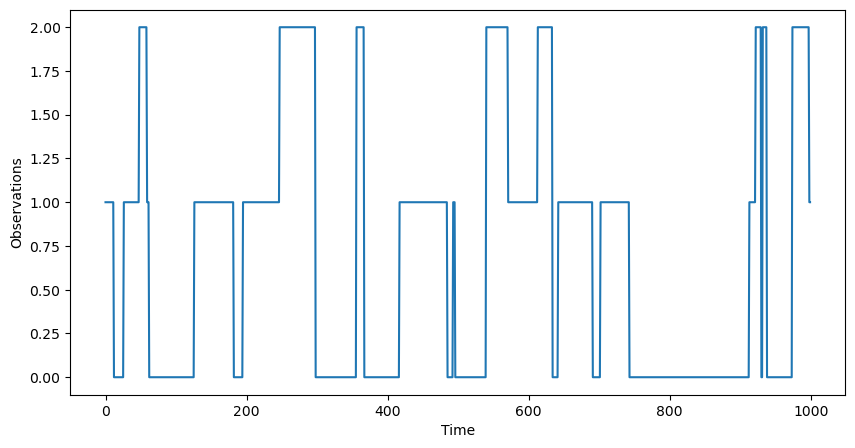

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations, markersize=2)
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [36]:
M = 2
A = 2
#Theta = np.random.randn(Y, M, M, A)

ThetaFollowSwitchFollow = np.zeros((Y, M, M, A))

# when receiving a zero observation, the memory is reset to zero and action 0 is taken
ThetaFollowSwitchFollow[0] = np.array([[[10, 0.01], [0.01, 0.01]],
                                      [[10, 0.01], [0.01, 0.01]]])

# when receiving a two observation, the memory is reset to one and action 1 is taken
ThetaFollowSwitchFollow[2] = np.array([[[0.01, 0.01], [0.01, 10]],
                                      [[0.01,0.01], [0.01, 10]]])

# when receiving a one observation, the memory keeps switching between 0 and 1 and the actions is random
ThetaFollowSwitchFollow[1] = np.array([[[0.01, 0.01], [10, 10]],
                                      [[10, 10], [0.01, 0.01]]])

Psi = np.array([1, 1])

FSC = FSC_DiscreteObs(ThetaFollowSwitchFollow, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


In [37]:
FSC.load_observations(observations)

In [38]:
NSteps = 200
trajectory = FSC.generate_single_trajectory(NSteps)
Time = np.arange(NSteps)

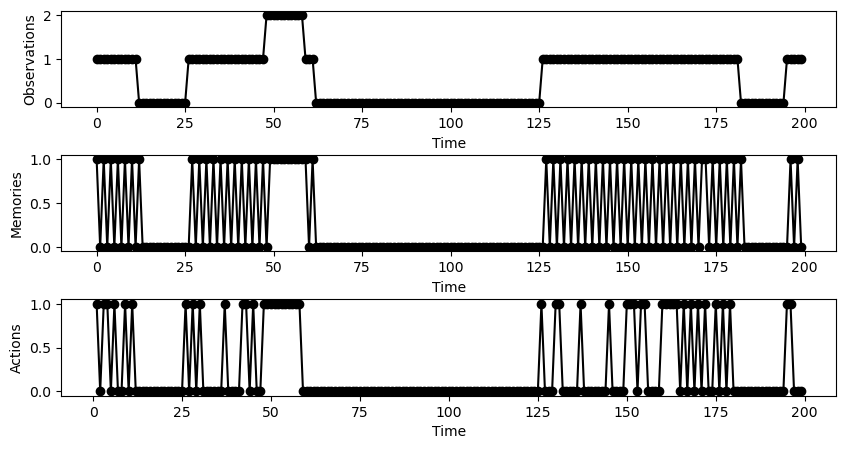

In [39]:
fig, ax = plt.subplots(3,1, figsize=(10,5))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(Time, trajectory["observations"], 'o', c= 'k')
ax[0].plot(Time, trajectory["observations"], c = 'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Observations')

ax[1].plot(Time, trajectory["memories"], 'o', c= 'k')
ax[1].plot(Time, trajectory["memories"], c = 'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Memories')

ax[2].plot(Time[1:], trajectory["actions"][1:], 'o', c= 'k')
ax[2].plot(Time[1:], trajectory["actions"][1:], c = 'k')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Actions')

plt.show()